밤하늘과 우주 혹은 관련 사물을 떠올리게 하는 곡
===
일단 rough 하게 서로 특징을 비교해보고, 시각화 결과를 보면서 정밀도를 높이는 방법과 분석에의 활용 방안을 고민해보기로 했다.

## 1. 시간에 따른 진폭 변화 (불필요한 내용이 되어 코드만 첨부)<br>
* 소리에서 진폭은 소리의 세기를 의미한다. 곡의 극적 전개, 기승전결이 뚜렷한 곡에서 진폭이 커지지 않을까 하는 생각이 들어 곡의 특징을 가장 잘 나타내는 부분을 잘라 시간에 따른 진폭 변화를 분석해보기로 했다.

In [12]:
import librosa, librosa.display, librosa.feature
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment

In [13]:
"""
meteor, sr = librosa.load(mp3file, sr=90, offset=10.357, duration=15.348)
time = np.linspace(10.357, 15.348, 1382) # time axis
fig, ax1 = plt.subplots() # plot
ax1.plot(time, meteor, color = 'b', label='speech waveform')
ax1.set_ylabel("Amplitude") # y 축
ax1.set_xlabel("Time [s]") # x 축
plt.title(file_id) # 제목
#plt.savefig(file_id+'.png')
plt.show()
"""

'\nmeteor, sr = librosa.load(mp3file, sr=90, offset=10.357, duration=15.348)\ntime = np.linspace(10.357, 15.348, 1382) # time axis\nfig, ax1 = plt.subplots() # plot\nax1.plot(time, meteor, color = \'b\', label=\'speech waveform\')\nax1.set_ylabel("Amplitude") # y 축\nax1.set_xlabel("Time [s]") # x 축\nplt.title(file_id) # 제목\n#plt.savefig(file_id+\'.png\')\nplt.show()\n'

### ! 여기까지 관찰 포인트
* 위 3개 그래프를 관찰해보면 첫번째 곡과 나머지 두 곡의 최대/최소값 범위 분포가 크게 차이나는 것을 볼 수 있다. 왜 이런 일이 생겼을까?
* 샘플링 비율을 44100에서 90으로 바꾸니 진폭의 값 분포 범위가 완전히 달라졌다.<br>
-> "샘플링 주파수(신호가 초당 샘플링되는 횟수)는 샘플링 속도라고 부릅니다. 샘플링 주파수가 높으면 재생할 수 있는 주파수 범위가 넓어집니다."<br>https://manual.yamaha.com/av/18/rxv485/ko-KR/341956619.html
* 계속 Pysound에 관련된 에러가 나는 것을 확인할 수 있다. 뿐만 아니라 그래프가 너무 촘촘해 파형을 제대로 알 수 없어 좀 더 넓은 시간의 간격으로 데이터를 추출해 새로운 데이터를 만드는 과정이 필요해 보였다. 이에 대해 찾아보니, librosa는 mp3 음원은 지원하지 않아 (py)soundfile로 바꿔야 한다는 사실을 알게 됐다. 앞으로의 데이터 분석을 위해서는 이 자료형이 필수적이었다.<br><br>
위와 같은 관찰 결과에서 **볼륨 정규화(normalize)** 과정이 필요하다고 판단했다. 아래와 같이 soundfile을 만든 뒤 정규화를 진행하려 한다.<br>
*참고 자료: https://keunwoochoi.blogspot.com/2019/05/blog-post_9.html, https://keunwoochoi.blogspot.com/2016/03/2.html, https://keunwoochoi.blogspot.com/2019/06/blog-post.html

## 2. 전처리에 대한 고민과 리서치
*  신호가 가지고 있는 정보를 최대한 보존하면서 **전체 데이터의 크기를 최소화**해야 효율적으로 연산을 할 수 있다.
* **decoding**: 한 선행 연구(논문)을 통해 **압축된 파일을 비압축 파형 데이터 형태로 복원해야 한다**는 것을 알게 되었다. 하지만 이걸 어떻게 하는지 여전히 **오리무중**이다.<br>
오디오 데이터 전처리에 대한 포스트(https://keunwoochoi.blogspot.com/2019/06/blog-post.html)를 참고해보면 디코딩을 하라는 이야기는 없고 **오히려 wav(int16)나 numpy array(int16/float32/etc)로 변환하라 말한다**. mp3는 압축된 형태고, wav는 그렇지 않은 형태로 용량이 훨씬 크다.<br>그러나 다른 포스트에선 오히려, mp3를 wav로 변환하는 것은 용량만 손해고 이득이 없다고 (https://it.donga.com/18897/)하여 **혼란스러운 상황**이다.
* **channel**: 모노/스테레오의 차이는 좌/우 채널 구분 여부에 불과하므로, 스테레오를 모노로 처리하는 것 이상의 처리는 필요하지 않다.
* **bitrate**: 세 음원 모두 비트레이트는 192kbps로 동일한 것을 확인했다. 따라서 파형 비교에 문제가 없을 것이다.<br>
### 1) 어떤 파일을 생성할 것인가?
* **soundfile 라이브러리를 이용해 pysoundfile을 만드는 법**: wav, flac 등 매우 다양한 형식으로 변환이 가능하다. float/double/int 만으로 이루어진 raw data도 만들 수 있다. 문제는 도대체 이 중 무엇을 선택해야 하는지 모르겠다는 것이다. 참고로 pysoundfile의 근본은 libsndfile이다. 가능한 subtype은 아래 코드를 통해 열거해두었다.

In [14]:
sf.available_subtypes()

{'PCM_S8': 'Signed 8 bit PCM',
 'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'FLOAT': '32 bit float',
 'DOUBLE': '64 bit float',
 'ULAW': 'U-Law',
 'ALAW': 'A-Law',
 'IMA_ADPCM': 'IMA ADPCM',
 'MS_ADPCM': 'Microsoft ADPCM',
 'GSM610': 'GSM 6.10',
 'G721_32': '32kbs G721 ADPCM',
 'G723_24': '24kbs G723 ADPCM',
 'DWVW_12': '12 bit DWVW',
 'DWVW_16': '16 bit DWVW',
 'DWVW_24': '24 bit DWVW',
 'VOX_ADPCM': 'VOX ADPCM',
 'DPCM_16': '16 bit DPCM',
 'DPCM_8': '8 bit DPCM',
 'VORBIS': 'Vorbis',
 'ALAC_16': '16 bit ALAC',
 'ALAC_20': '20 bit ALAC',
 'ALAC_24': '24 bit ALAC',
 'ALAC_32': '32 bit ALAC'}

디코딩 방법엔 3가지가 있었다. 1)소프트웨어 사용 2)MacOS 패키지 관리자 homebrew를 통해 설치한 ffmpeg 사용 3)c++ code 사용<br>그 중 첫번째 방법은 하지 않고 나머지 두 방법만 시도를 해보았다.

#### 두번째 방법 시도
ffmpeg 디코딩 결과 파일을 보고 이를 다시 raw, wav 등의 파일로 변환한다.
이 중 두번째 방법을 사용하려 시도했으나, 디코딩에 대한 여전한 의문으로 사용하지 못했다.

#### 세번째 방법 시도
core.block_read를 통해 곡 전체를 읽어온다. 단, 이 방법은 곡 분석 전략을 정하기 전에는 사용하지 않기로 했다. 파트별로 쪼개서 파트별로 서로 비교를 한다던가, 전체 한 다음에 spectrum 특징 중심으로 백그라운드 뮤직 중심으로 살펴본다던가(karaoke/instrumental 음원을 사용한다던가)... 그냥은 안됨. 곡의 전개를 어떻게 분석할 것인가... 이런 것도 그렇고, 결국은 특징을 잘 나타내는 부분을 따로 떼어와서 분석할 수밖에 없음.

결론: 디코딩 매커니즘을 알아냈다. 디코딩으로 산출되어야 할 결과물은 순수 파동으로 이루어진 데이터이고, 이에 대해 고속 푸리에 변환을 거쳐야 하는 것이다. 하지만 정말 여러 가지를 알아봤는데, 결론적으로 보통 ffmpeg를 거쳐 wav로 변환하면 된다는 것이 중론이었다. 따라서 이 방법대로 하기로 했다. 이떄 pydub라는 파이썬으로 구현된 ffmpeg mp3 디코더 라이브러리를 사용하기로 했다.

In [15]:
#sound = AudioSegment.from_mp3("mikrokosmos.mp3")
#sound.export("mikrokosmos.wav", format="wav")
"""
sound = AudioSegment.from_mp3("meteor.mp3")
sound.export("meteor.wav", format="wav")
sound = AudioSegment.from_mp3("magicshop.mp3")
sound.export("magicshop.wav", format="wav")
sound = AudioSegment.from_mp3("thefeeling.mp3")
sound.export("thefeeling.wav", format="wav")
sound = AudioSegment.from_mp3("askyfullofstars.mp3")
sound.export("askyfullofstars.wav", format="wav")
sound = AudioSegment.from_mp3("bluemoon_inst.mp3")
sound.export("bluemoon_inst.wav", format="wav")
sound = AudioSegment.from_mp3("heavenisaplace.mp3")
sound.export("heavenisaplace.wav", format="wav")
sound = AudioSegment.from_mp3("rewritethestars_inst.mp3")
sound.export("rewritethestars_inst.wav", format="wav")
"""

'\nsound = AudioSegment.from_mp3("meteor.mp3")\nsound.export("meteor.wav", format="wav")\nsound = AudioSegment.from_mp3("magicshop.mp3")\nsound.export("magicshop.wav", format="wav")\nsound = AudioSegment.from_mp3("thefeeling.mp3")\nsound.export("thefeeling.wav", format="wav")\nsound = AudioSegment.from_mp3("askyfullofstars.mp3")\nsound.export("askyfullofstars.wav", format="wav")\nsound = AudioSegment.from_mp3("bluemoon_inst.mp3")\nsound.export("bluemoon_inst.wav", format="wav")\nsound = AudioSegment.from_mp3("heavenisaplace.mp3")\nsound.export("heavenisaplace.wav", format="wav")\nsound = AudioSegment.from_mp3("rewritethestars_inst.mp3")\nsound.export("rewritethestars_inst.wav", format="wav")\n'

## 3. 원하는 구간 잘라내어 pysoundfile 파일 만들기

In [16]:
"""
mikrokosmos1, sr = sf.read('mikrokosmos.wav', stop=4.294, dtype='int16', samplerate=90, channels=90)
#sf.write('mikrokosmos1.raw', mikrokosmos1, 90, subtype='FLOAT')
print(mikrokosmos1)
"""

"\nmikrokosmos1, sr = sf.read('mikrokosmos.wav', stop=4.294, dtype='int16', samplerate=90, channels=90)\n#sf.write('mikrokosmos1.raw', mikrokosmos1, 90, subtype='FLOAT')\nprint(mikrokosmos1)\n"

충격적이게도 구간을 정수 단위로밖에 자르지 못한다. 그냥 소프트웨어를 이용해 필요한 구간을 full wav 파일로 자르기로 했다.

## 4. Feature Extraction
이 카테고리에 속한 곡들에 대해서 다음과 같은 것들을 분석해보고자 한다.
* **Magnitude scaling**: 한 곡(meteor.wav)을 제외하고 모든 곡의 전개가 비슷하다. 처음엔 우주를 묘사하는 듯한 인트로 반주로 시작한다. 1절까지는 비슷한 규모, 분위기를 가진다. 하이라이트 구간이 되기 전 음악의 공간감, 규모가 증폭된다. 하이라이트에서 이전보다 화려한 소리를 선사한다. 따라서 곡 상에서 공간감(혹은 볼륨, 혹은 규모)이 커지는 부분의 위치 변화 정도(최저값, 최고값, 변화율 등)<br>
* **Rhythm Features**: 박자 면에서 어느 정도 유사도를 가지는지 파악해본다. 같은 카테고리 속 곡보단 다른 카테고리의 곡들과 비교했을 때 확실하게 두드러질 것이다.
* **Beat and Tempo**: 속도 면에서 어느 정도 유사도를 가지는지 파악해본다. 같은 카테고리 속 곡보단 다른 카테고리의 곡들과 비교했을 때 확실하게 두드러질 것이다.
* **Spectral features**

### **1) Spectral features**
#### (1) Time Domain Amplitude Waveform

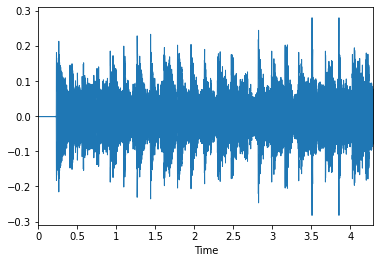

In [17]:
mikrokosmos, sr = librosa.load('mikrokosmos.wav', sr=44100, duration=4.294)
librosa.display.waveplot(mikrokosmos, sr)

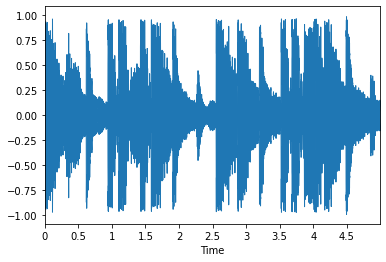

In [18]:
# offset=10.357, duration=15.348
meteor, sr = librosa.load('meteor.wav', sr=44100, offset=10.357, duration=4.991)
librosa.display.waveplot(meteor, sr)

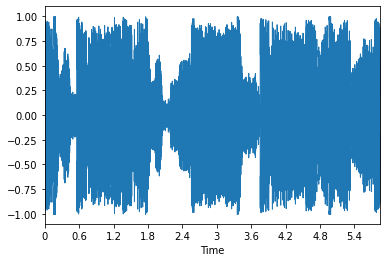

In [19]:
#얘도 inst 음원으로 바꾸기
magicshop, sr = librosa.load('magicshop.wav', sr=44100, offset=220.426, duration=5.841)
librosa.display.waveplot(magicshop, sr)

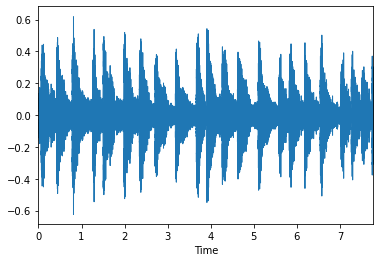

In [20]:
asfos, sr = librosa.load('askyfullofstars.wav', sr=44100, offset=7.741, duration=7.776)
librosa.display.waveplot(asfos, sr)

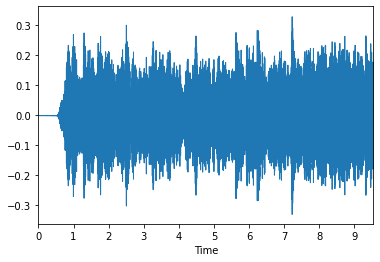

In [21]:
# 얘도 inst 음원으로 바꾸기
feeling, sr = librosa.load('thefeeling.wav', sr=44100, duration=9.538)
librosa.display.waveplot(feeling, sr)

#### (2) short time fourier transform => power spectogram (Magnitude scaling)
* **STFT(short time fourier transform)란?**<br>
데이터에서 시간에 대해 구간을 짧게 나누어 나누어진 여러 구간의 데이터를 각각 푸리에 변환하는 방법. 자동차의 가속신호, transient 신호처럼 시간에 따라 특성이 변하는 신호를 분석하는데 사용된다.<br>**이를 하는 이유를 알 수 있는 내용을 추가하자.**

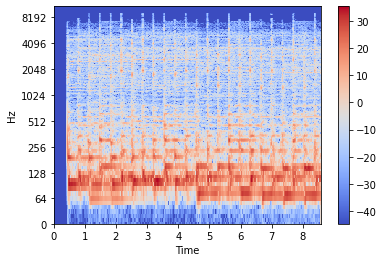

In [22]:
mikrokosmos_sftf = np.abs(librosa.stft(mikrokosmos))
librosa.display.specshow(librosa.amplitude_to_db(mikrokosmos_sftf), x_axis='time', y_axis='log')
plt.colorbar()

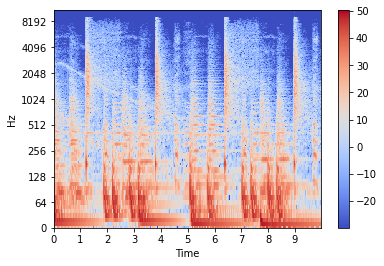

In [23]:
meteor_sftf = np.abs(librosa.stft(meteor))
librosa.display.specshow(librosa.amplitude_to_db(meteor_sftf), x_axis='time', y_axis='log')
plt.colorbar()

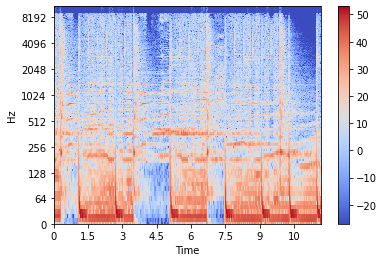

In [24]:
magicshop_stft = np.abs(librosa.stft(magicshop))
librosa.display.specshow(librosa.amplitude_to_db(magicshop_stft), x_axis='time', y_axis='log')
plt.colorbar()

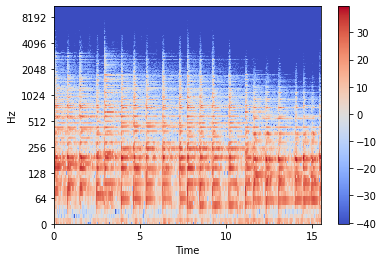

In [25]:
asfos_stft = np.abs(librosa.stft(asfos))
librosa.display.specshow(librosa.amplitude_to_db(asfos_stft), x_axis='time', y_axis='log')
plt.colorbar()

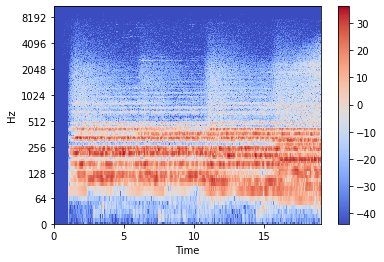

In [26]:
feeling_stft = np.abs(librosa.stft(feeling))
librosa.display.specshow(librosa.amplitude_to_db(feeling_stft), x_axis='time', y_axis='log')
plt.colorbar()

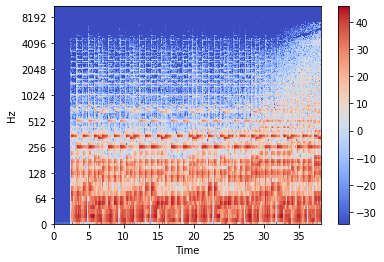

In [27]:
bluemoon, sr = librosa.load('bluemoon_inst.wav', sr=44100, duration=19.118)
bluemoon_stft = np.abs(librosa.stft(bluemoon))
librosa.display.specshow(librosa.amplitude_to_db(bluemoon_stft), x_axis='time', y_axis='log')
plt.colorbar()

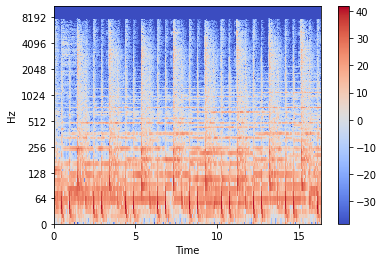

In [28]:
heaven, sr = librosa.load('heavenisaplace.wav', sr=44100, offset=40.837, duration=8.165)
heaven_stft = np.abs(librosa.stft(heaven))
librosa.display.specshow(librosa.amplitude_to_db(heaven_stft), x_axis='time', y_axis='log')
plt.colorbar()

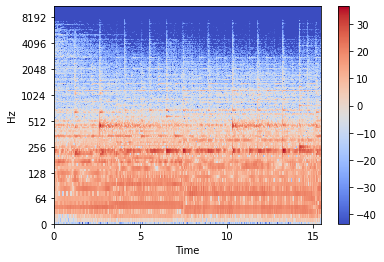

In [41]:
rewrite, sr = librosa.load('rewritethestars_inst.wav', sr=44100, offset= 16.02, duration=7.728)
rewrite_stft = np.abs(librosa.stft(rewrite))
librosa.display.specshow(librosa.amplitude_to_db(rewrite_stft), x_axis='time', y_axis='log')
plt.colorbar()

### ! 여기까지 관찰 포인트
* 도입부 혹은 (도입부가 너무 짧은 경우, 즉 3초 미만인 경우)간주 부분을 비교했는데 아래 두 곡이 위 세 곡과 격차가 심해 보인다.

#### (3) Mel-scale spectrogram
사람의 가청 주파수인 8000Hz 이하의 주파수에 대해서만 scaling하여 spectrogram을 만드는 것.

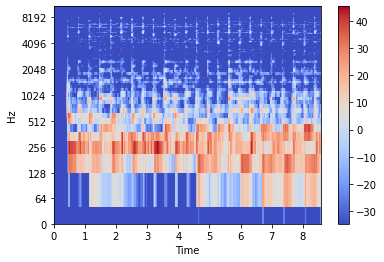

In [30]:
mikrokosmos_mel = librosa.feature.melspectrogram(S=mikrokosmos_sftf**2)
librosa.display.specshow(librosa.amplitude_to_db(mikrokosmos_mel), x_axis='time', y_axis='log')
plt.colorbar()

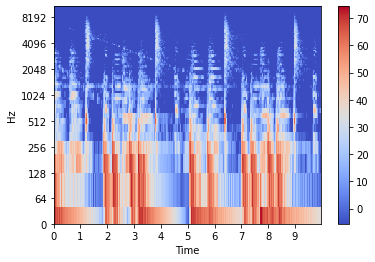

In [31]:
meteor_mel = librosa.feature.melspectrogram(S=meteor_sftf**2)
librosa.display.specshow(librosa.amplitude_to_db(meteor_mel), x_axis='time', y_axis='log')
plt.colorbar()

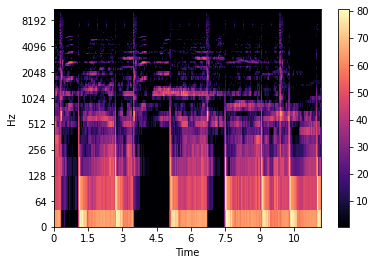

In [32]:
magicshop_mel = librosa.feature.melspectrogram(S=magicshop_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(magicshop_mel), x_axis='time', y_axis='log')
plt.colorbar()

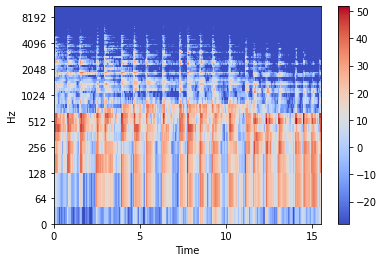

In [33]:
asfos_mel = librosa.feature.melspectrogram(S=asfos_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(asfos_mel), x_axis='time', y_axis='log')
plt.colorbar()

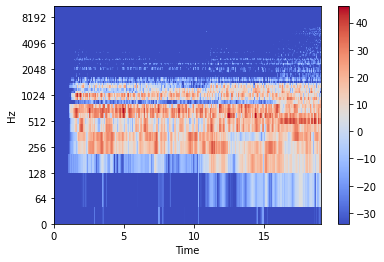

In [34]:
feeling_mel = librosa.feature.melspectrogram(S=feeling_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(feeling_mel), x_axis='time', y_axis='log')
plt.colorbar()

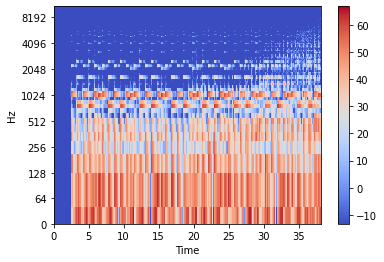

In [35]:
bluemoon_mel = librosa.feature.melspectrogram(S=bluemoon_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(bluemoon_mel), x_axis='time', y_axis='log')
plt.colorbar()

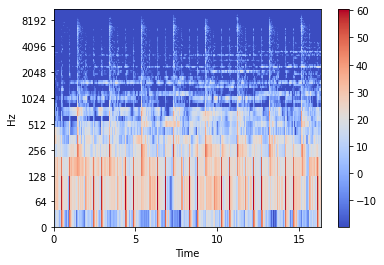

In [36]:
heaven_mel = librosa.feature.melspectrogram(S=heaven_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(heaven_mel), x_axis='time', y_axis='log')
plt.colorbar()

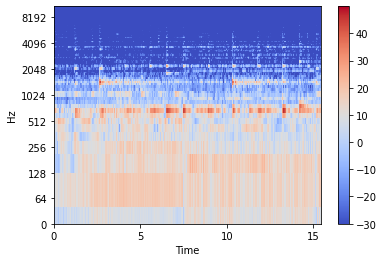

In [42]:
rewrite_mel = librosa.feature.melspectrogram(S=rewrite_stft**2)
librosa.display.specshow(librosa.amplitude_to_db(rewrite_mel), x_axis='time', y_axis='log')
plt.colorbar()

### 2) Tempo Features(Tempogram)
#### (1) Novelty Function

In [55]:
hop_length = 200 # samples per frame
n0 = 100
n1 = 500

Text(0.5, 1.0, 'Novelty Function')

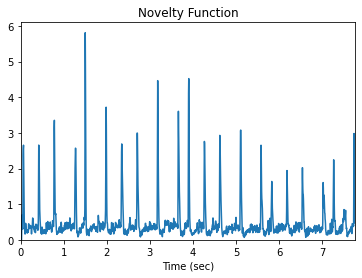

In [52]:
asfos_onset_env = librosa.onset.onset_strength(asfos, sr=sr, hop_length=hop_length, n_fft=2048)
# Plot the onset envelope
frames = range(len(asfos_onset_env))
asfos_t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(t, asfos_onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

Text(0.5, 1.0, 'Novelty Function')

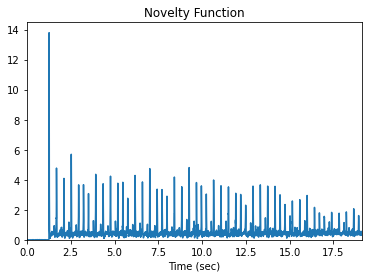

In [59]:
bluemoon_onset_env = librosa.onset.onset_strength(bluemoon, sr=sr, hop_length=hop_length, n_fft=2048)
# Plot the onset envelope
frames = range(len(bluemoon_onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(t, bluemoon_onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

Text(0.5, 1.0, 'Novelty Function')

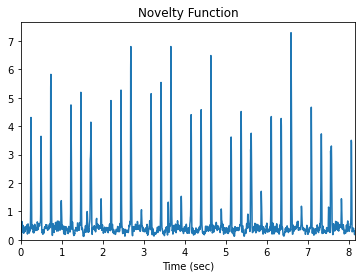

In [60]:
heaven_onset_env = librosa.onset.onset_strength(heaven, sr=sr, hop_length=hop_length, n_fft=2048)
# Plot the onset envelope
frames = range(len(heaven_onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(t, heaven_onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

Text(0.5, 1.0, 'Novelty Function')

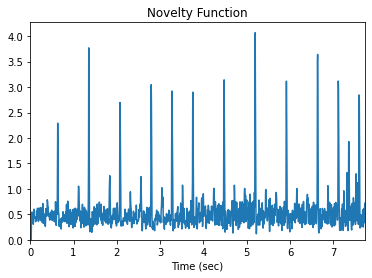

In [61]:
rewrite_onset_env = librosa.onset.onset_strength(rewrite, sr=sr, hop_length=hop_length, n_fft=2048)
# Plot the onset envelope
frames = range(len(rewrite_onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(t, rewrite_onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

#### (2) Fourier Tempogram

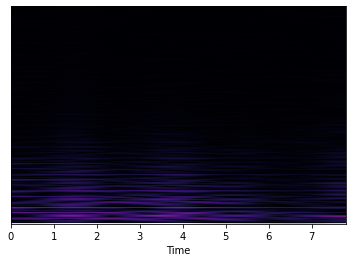

In [54]:
S = librosa.stft(asfos_onset_env, hop_length=1, n_fft=512)
asfos_fourier_tempogram = np.absolute(S)
librosa.display.specshow(asfos_fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

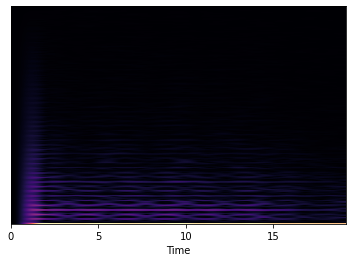

In [62]:
S = librosa.stft(bluemoon_onset_env, hop_length=1, n_fft=512)
bluemoon_fourier_tempogram = np.absolute(S)
librosa.display.specshow(bluemoon_fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

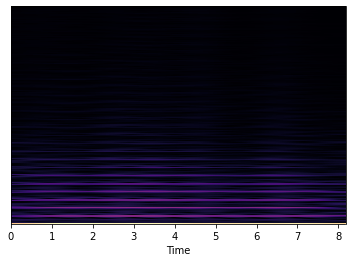

In [64]:
S = librosa.stft(heaven_onset_env, hop_length=1, n_fft=512)
heaven_fourier_tempogram = np.absolute(S)
librosa.display.specshow(heaven_fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

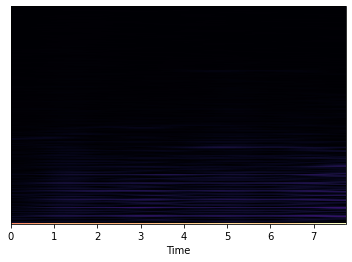

In [65]:
S = librosa.stft(rewrite_onset_env, hop_length=1, n_fft=512)
rewrite_fourier_tempogram = np.absolute(S)
librosa.display.specshow(rewrite_fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

#### (3) Autocorrelation Tempogram

Text(0.5, 1.0, 'Novelty Function')

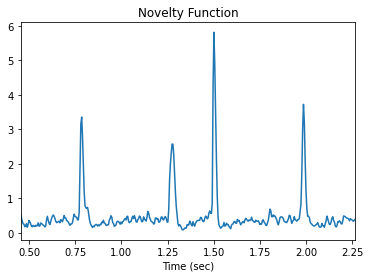

In [66]:
plt.plot(t[n0:n1], asfos_onset_env[n0:n1])
plt.xlim(t[n0], t[n1])
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

(0.0, 79.28193507116482)

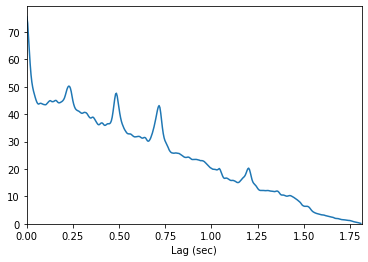

In [68]:
tmp = np.log1p(onset_env[n0:n1])
r = librosa.autocorrelate(tmp)
plt.plot(t[:n1-n0], r)
plt.xlim(t[0], t[n1-n0])
plt.xlabel('Lag (sec)')
plt.ylim(0)